<a href="https://colab.research.google.com/github/cloudsen12/examples/blob/master/example02.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

<br>

<a href="https://github.com/cloudsen12/examples/blob/main/example02.ipynb"><img align="left" src="https://img.shields.io/badge/github-%23121011.svg?style=for-the-badge&logo=github&logoColor=white"></a>


<br><br>

<!--COURSE_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://cloudsen12.github.io/thumbnails/cloudsen12.gif" width=10% >


>>>> *This notebook is part of the paper [CloudSEN12 - a global dataset for semantic understanding of cloud and cloud shadow in Sentinel-2](https://cloudsen12.github.io/); the content is available [on GitHub](https://github.com/cloudsen12)* and released under the [MIT](https://opensource.org/licenses/MIT) license. 

<br>

- See our paper [here](https://www.nature.com/articles/s41597-022-01878-2).

- See cloudSEN12 website [here](https://cloudsen12.github.io/).

- See cloudSEN12 in Science Data Bank [here](https://www.scidb.cn/en/detail?dataSetId=f72d622ff4ea4fa18070456a98222b1a).

- See cloudSEN12 in Google Drive [here](https://drive.google.com/drive/folders/1H_Qxy1yX6moqFbKc3Ajn4FFrHlDhYuz3).

- See cloudSEN12 in GitHub [here](https://github.com/cloudsen12).

- See cloudSEN12 in Google Earth Engine [here](https://samapriya.github.io/awesome-gee-community-datasets/projects/cloudsen12/).

- See CloudApp [here](https://csaybar.users.earthengine.app/view/cloudapp).

The CloudSEN12 dataset and the pre-trained models are released under a [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) licence. For using the models in comercial pipelines written consent by the authors must be provided.

### **1. Install the cloudsen12 Python package**

In [ ]:
!pip install s2cloudless cloudsen12

**warning: Restart runtime before to proceed**

### **2. Load cloudSEN12 STAC**

In [ ]:
import cloudsen12
import s2cloudless

s2cloudless_cprob = s2cloudless.S2PixelCloudDetector()
cloudsen12_stac = cloudsen12.load()

Downloading...
From: https://drive.google.com/uc?id=1oepqeteGXKJCXzIRzc6lXpNEV5eFGGsF
To: /root/.config/cloudsen12/cloudsen12_stac.pkl
100%|██████████| 183M/183M [00:02<00:00, 67.9MB/s]


### **3. Select only nolabel subset**

In [ ]:
import datetime

# Filter by properties
query = {
    "label_type": {"eq": ["nolabel"]},
    "cloud_coverage": {"eq": ["low-cloudy", "mid-cloudy"]}
}

# Filter by dates
init_date = datetime.datetime.strptime("2018-01-01", '%Y-%m-%d')
last_date = datetime.datetime.strptime("2018-12-31", '%Y-%m-%d')
datetime = [init_date, last_date]


# Make a query :3
cloudsen12_stac_filtered = cloudsen12_stac.search(
    bbox=None,
    datetime=datetime,
    query=query
)

cloudsen12_stac_nolabel = cloudsen12_stac_filtered

### **4. Select a random items with no labels**

In [ ]:
import random

# get a list of all the items id
counter = 0
id_container = list()
for item in cloudsen12_stac_nolabel.get_all_items():
    id_container.append(item.id)
    counter += 1

# select randomly 5 items
to_display = random.sample(range(counter), 5)
items_to_display = [id_container[index] for index in to_display]

### **5. Compare models**

In [ ]:
# @title plot functions
from matplotlib import colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import torch

# Load UnetMobV2 model
unetmobv2 = cloudsen12.UnetMobV2().model
unetmobv2.eval()


COLORS_CLOUDSEN12 = np.array(
    [[139, 64, 0], # clear
    [220, 220, 220], # Thick cloud
    [180, 180, 180], # Thin cloud
    [60, 60, 60]], # cloud shadow
    dtype=np.float32
) / 255
INTERPRETATION_CLOUDSEN12 = ["clear", "Thick cloud", "Thin cloud", "Cloud shadow"]

def plot_segmentation_mask(mask, color_array, interpretation_array=None,legend:bool=True, ax=None):
    """
    Args:
        mask: (H, W) np.array
        color_array: colors for values 0,...,len(color_array)-1 of mask
        interpretation_array: interpretation for classes 0, ..., len(color_array)-1
        
    """
    cmap_categorical = colors.ListedColormap(color_array)
    
    norm_categorical = colors.Normalize(vmin=-.5,
                                        vmax=color_array.shape[0]-.5)
    
    color_array = np.array(color_array)
    if interpretation_array is not None:
        assert len(interpretation_array) == color_array.shape[0], f"Different numbers of colors and interpretation {len(interpretation_array)} {color_array.shape[0]}"
    
    
    if ax is None:
        ax = plt.gca()
    
    ax.imshow(mask, cmap=cmap_categorical, norm=norm_categorical,interpolation='nearest')
    if legend:
        patches = []
        for c, interp in zip(color_array, interpretation_array):
            patches.append(mpatches.Patch(color=c, label=interp))
        
        ax.legend(handles=patches,
                  loc='upper right')
    return ax


def plot_cloudSEN12mask(mask, legend:bool=True, ax=None):
    """
    Args:
        mask: (H, W) np.array        
    """
    
    return plot_segmentation_mask(mask=mask,color_array=COLORS_CLOUDSEN12,interpretation_array=INTERPRETATION_CLOUDSEN12,legend=legend,ax=ax)

def display_all_models(item_id):

  # Select a STAC item
  stac_item = cloudsen12_stac_nolabel.get_item(item_id)

  # Get cloud semantics in a S2L1C 509x509 tile
  with rio.open(stac_item.assets["S2L1C"].href) as r:
    s2np = r.read()
    # from 509 x 509 to 512x512
    s2np_padded = np.pad(s2np, ((0, 0), (1, 2),(1, 2)), 'reflect') / 10000
    s2np_padded = s2np_padded[None, ...]

    # Make a prediction
    cloud_prob = unetmobv2(torch.Tensor(s2np_padded))

    # from torch to numpy
    cloud_prob_np = cloud_prob.squeeze().detach().numpy()
    cloud_prob_np = cloud_prob_np[:, 1:-2, 1:-2] # remove padding

    # apply argmax
    unetmobv2_cloudmask = np.argmax(cloud_prob_np, axis = 0)


  # Load Sen2Cor results
  with rio.open(stac_item.assets["sen2cor"].href) as r:
    sen2cornp = r.read()
    # from 11 classes to 4 classes
    thick_cloud = (sen2cornp  == 9) | (sen2cornp  == 8)
    thin_cloud = (sen2cornp  == 10)
    cloud_shadow = (sen2cornp  == 3)
    clear = (
      (sen2cornp  == 1) | (sen2cornp  == 2) | (sen2cornp  == 4) |
      (sen2cornp  == 5) | (sen2cornp  == 6) | (sen2cornp  == 7) |
      (sen2cornp  == 11)
    )
    
    # apply argmax
    sen2cor_cloudmask = np.concatenate(
        [clear, thick_cloud, thin_cloud, cloud_shadow], 
        axis=0
    ).argmax(axis=0)


  # Load s2cloudless results
  with rio.open(stac_item.assets["s2cloudless"].href) as r:
    s2cloudlessnp = r.read()/100
    s2cloudless_cloudmask = s2cloudless_cprob.get_mask_from_prob(s2cloudlessnp).squeeze()


  # Load kappamask_L1C results
  with rio.open(stac_item.assets["kappamask_L1C"].href) as r:
    kappamasknp = r.read()
    clear = kappamasknp == 1
    thick_cloud = kappamasknp == 4
    thin_cloud = kappamasknp == 3
    cloud_shadow = kappamasknp == 2

    # apply argmax
    kappamask_cloudmask = np.concatenate(
        [clear, thick_cloud, thin_cloud, cloud_shadow], 
        axis=0
    ).argmax(axis=0)

  # Load Fmask results
  with rio.open(stac_item.assets["fmask"].href) as r:
    fmasknp = r.read()
    clear = (fmasknp == 0) | (fmasknp == 1) | (fmasknp == 3)
    thick_cloud = fmasknp == 4
    thin_cloud = fmasknp*0
    cloud_shadow = fmasknp == 2

    # apply argmax
    fmask_cloudmask = np.concatenate(
        [clear, thick_cloud, thick_cloud, cloud_shadow], 
        axis=0
    ).argmax(axis=0)

  # Create a RGB 
  rgb = np.moveaxis(s2np[[3, 2, 1], ...]/3000, 0, 2)


  # Display all the bands
  fig, ax = plt.subplots(2, 3, figsize=(30, 20), tight_layout=False)

  # Plot RGB
  ax[0,0].imshow(rgb)
  ax[0,0].set_title("RGB")

  # Plot UNetMobV2
  plot_cloudSEN12mask(unetmobv2_cloudmask, ax=ax[0, 1], legend=False)
  ax[0, 1].set_title("UnetMobv2")


  plot_cloudSEN12mask(sen2cor_cloudmask, ax=ax[0, 2], legend=False)
  ax[0, 2].set_title("Sen2Cor")


  plot_cloudSEN12mask(s2cloudless_cloudmask, ax=ax[1, 0], legend=False)
  ax[1, 0].set_title("s2cloudless")


  plot_cloudSEN12mask(kappamask_cloudmask, ax=ax[1, 1], legend=False)
  ax[1, 1].set_title("KappaMask L1C")


  plot_cloudSEN12mask(fmask_cloudmask, ax=ax[1, 2], legend=True)
  ax[1, 2].set_title("Fmask")

Downloading...
From: https://drive.google.com/uc?id=1o9LeVsXCeD2jmS-G8s7ZISfciaP9v-DU
To: /root/.config/maskaymodels/unetmobv2.ckpt
100%|██████████| 80.0M/80.0M [00:01<00:00, 51.3MB/s]


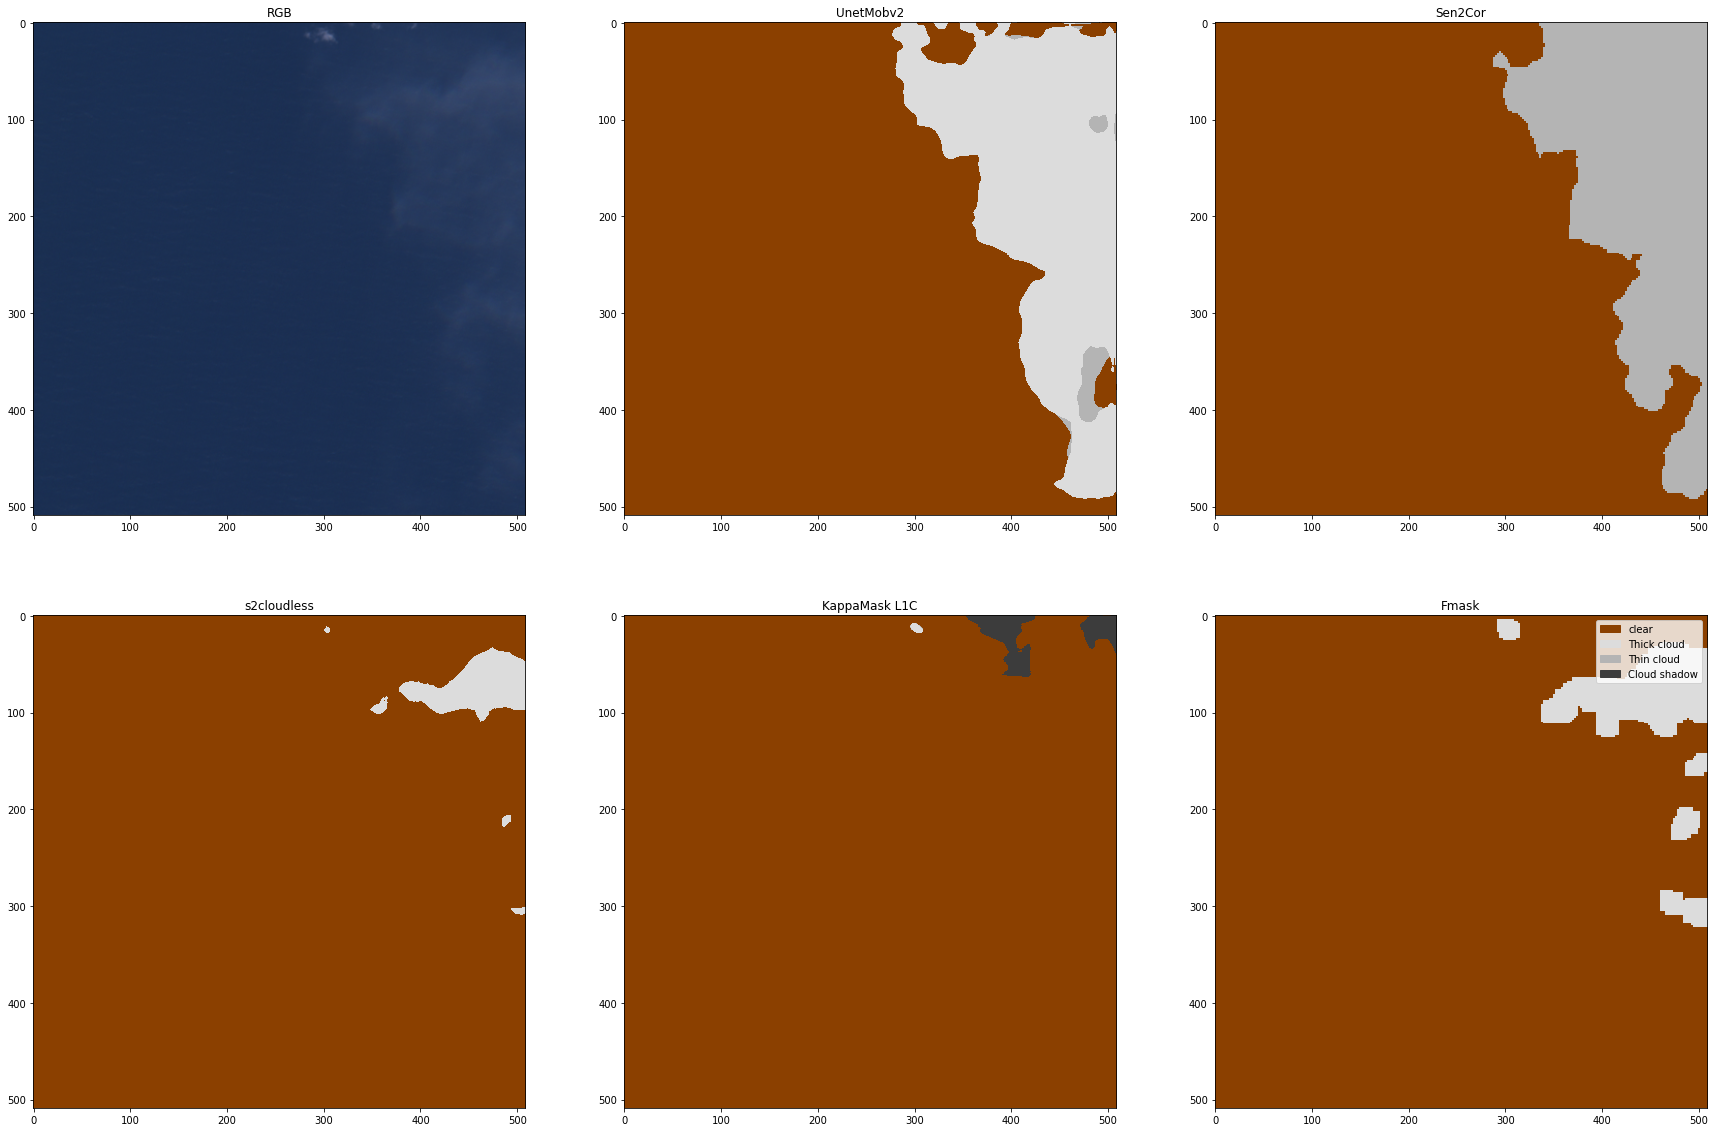

In [ ]:
display_all_models(item_id=items_to_display[0])

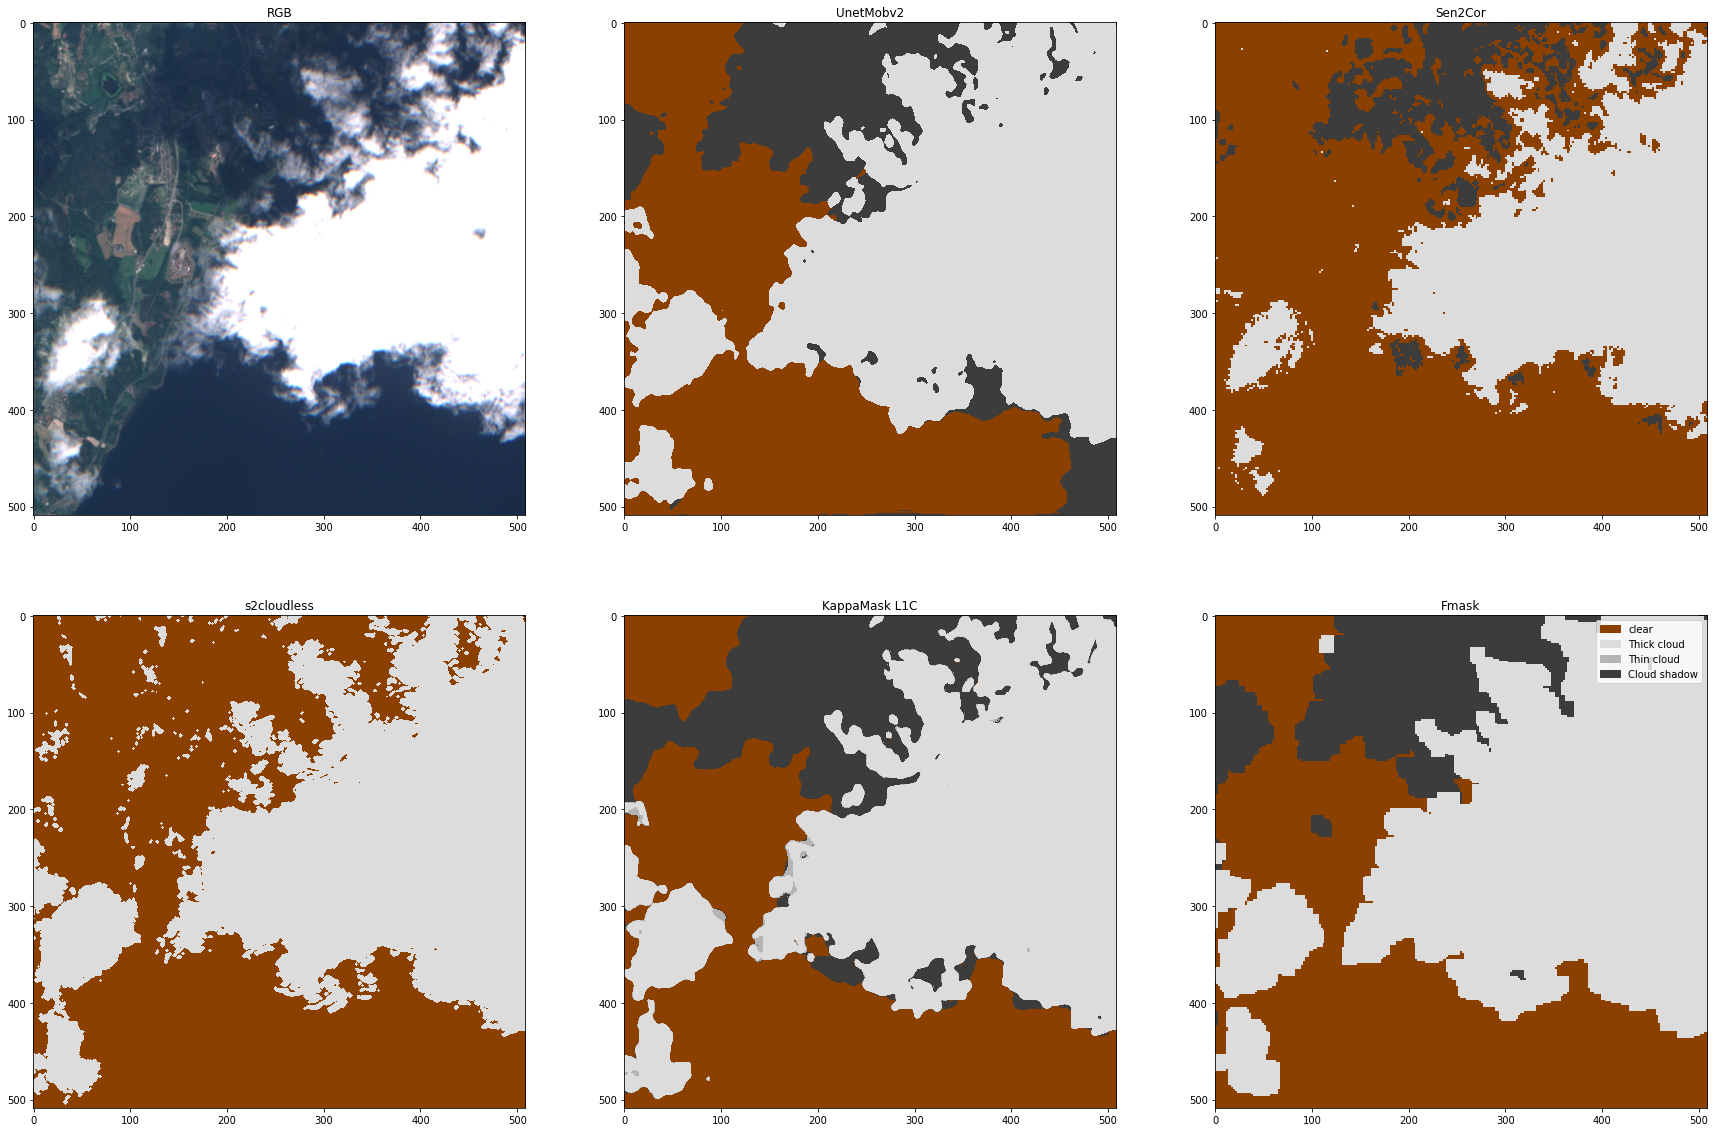

In [ ]:
display_all_models(item_id=items_to_display[1])

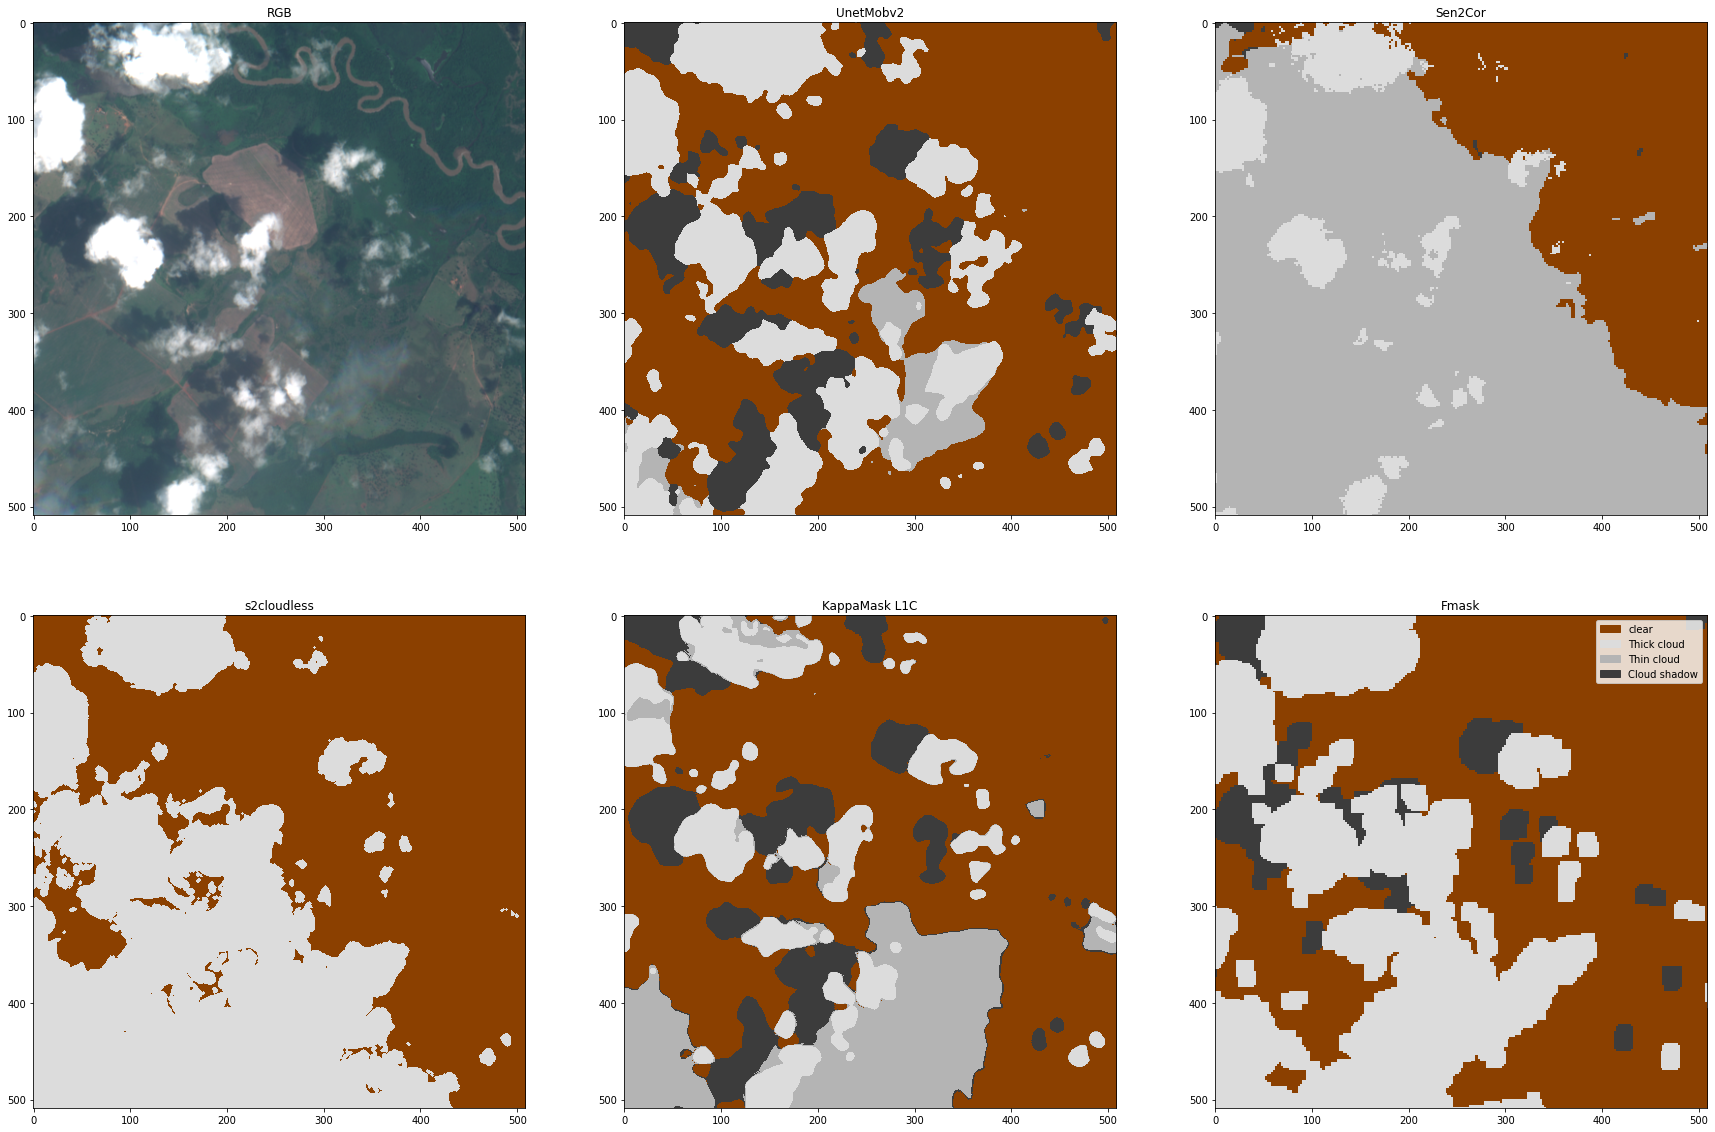

In [ ]:
display_all_models(item_id=items_to_display[2])

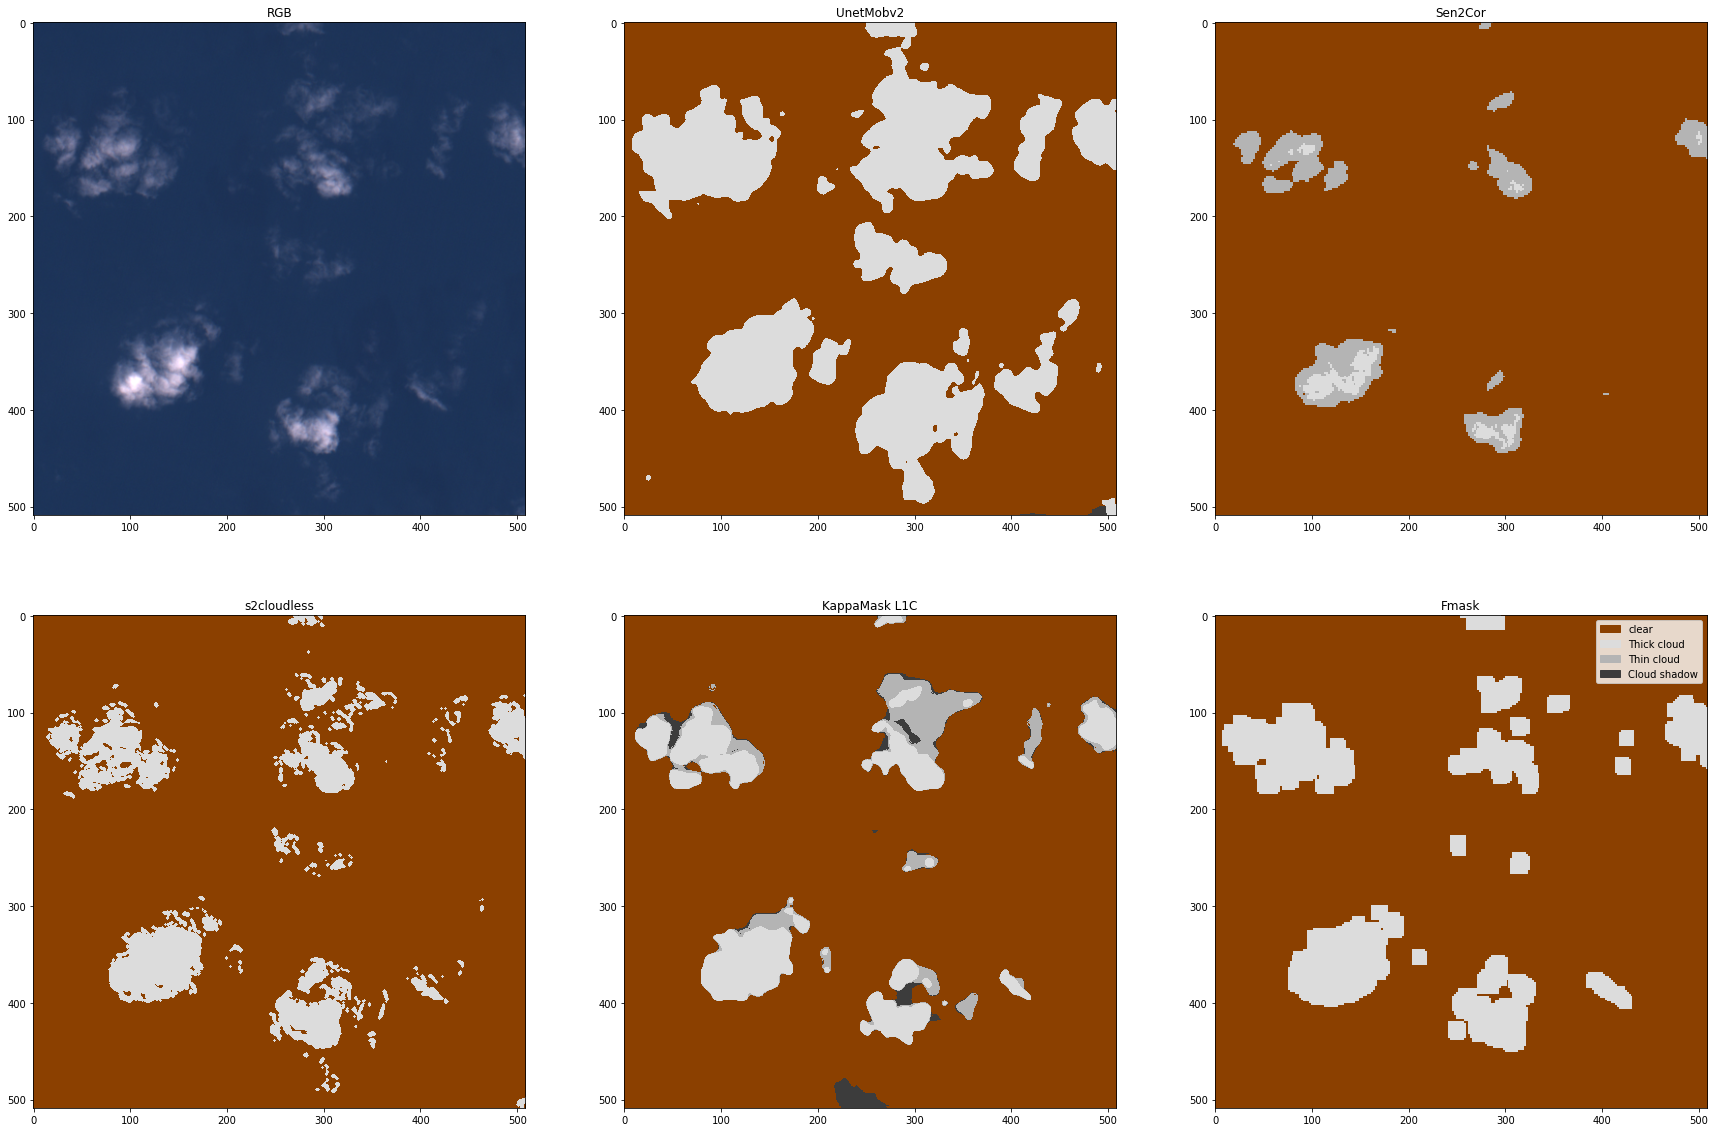

In [ ]:
display_all_models(item_id=items_to_display[3])

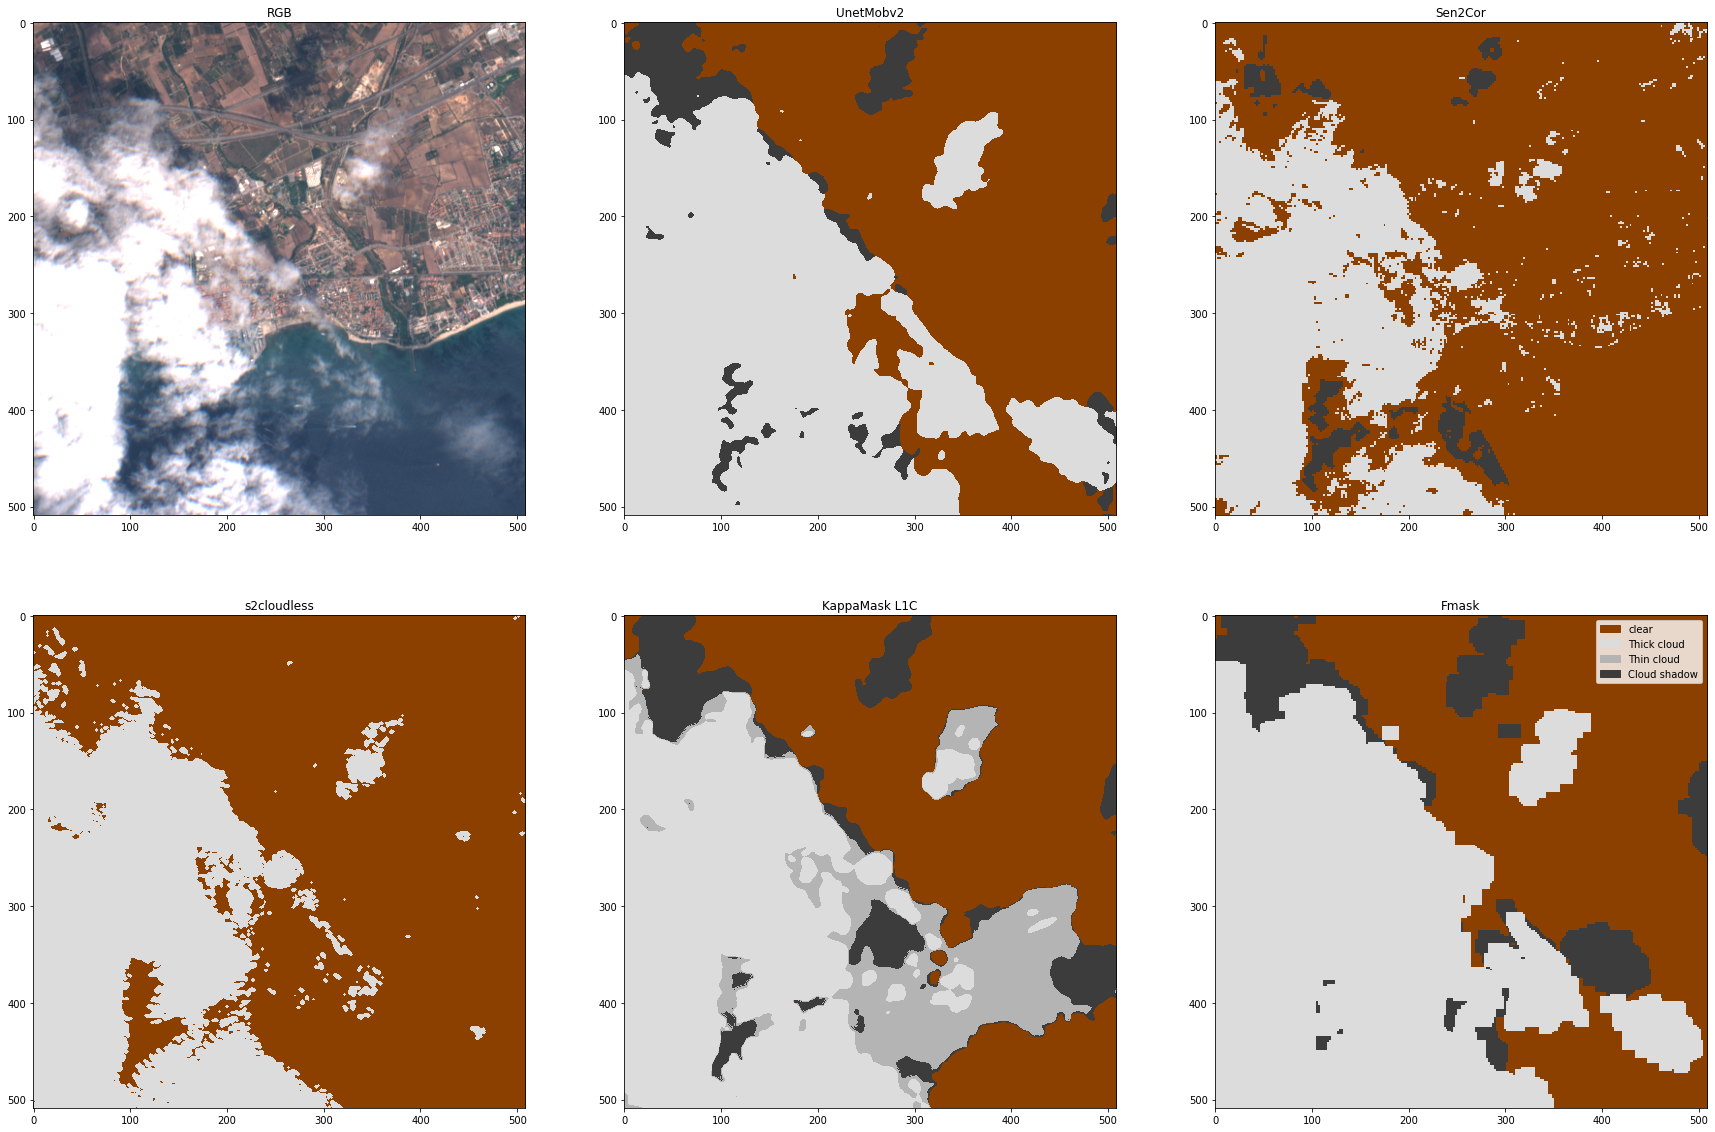

In [ ]:
display_all_models(item_id=items_to_display[4])